<a href="https://colab.research.google.com/github/AgustinCocciardi/TP-Ciencia-de-Datos/blob/main/Copia_de_Copia_de_TP_EntregableVirus_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examen Práctico

#### 01-3900 | Ciencia de datos | 2024

Alumno: Cocciardi Agustin Ignacio

## Enunciado

Se tienen un dataset con datos de pacientes internados en un hospital (TP_Virus_Alumnos.csv). La clase de interes (1) refiere a la presencia de un virus. El virus tiene normalmente una gravedad leve/baja y el tratamiento suele ser invasivo. Datos como nombre y apellido han sido eliminados y los valores tanto en sangre (BLD), hormonales u otros análisis sobre reactivos han sido alterados en sus valores para preservar la privacidad. Se aclara que no se ha modificado su capacidad predictiva (Si es que la tienen).


Para su conocimiento: </BR>
Datos generales de Edad, Peso, Altura y condición laboral (Activo, Pasivo etc).
Datos medidos en hospital:</BR>
BLD: Sangre</BR>
LVL: Hormonales</BR>
REC: Otros análisis</BR>

Se pide obtener con los datos disponibles el mejor modelo posible que prediga la presencia o ausencia del virus.
Dado que el tratamiento es invasivo y la grevedad es moderada se requiere "atrapar" tantos "1" como sea posible y minimizar los falsos positivos para evitar que reciban un tratamiento de estas caracteristicas personas que no presentan el virus. Intente obtener el mejor modelo que maximice la métrica que considere correspondiente.



## Como desarrollar el exámen

A partir del dataset realice todas las acciones para poder llegar al mejor modelo, explique brevemente en los fundamentos de sus transformaciones o acciones en general.

La nota derivará de: </BR>
1.La calidad de la clasificación realizada</BR>
2.La fundamentación de los pasos realizados</BR>
3.Lo sencillo de llevar a producción el desarrollo</BR>



Los docentes evaluaran su clasificador utilizando un conjunto de datos del dataset "fuera de la caja" (out of the box, al que usted no tiene acceso). Para minimizar la posible diferencia entre su medición y la medición del docente recuerde y aplique conceptos de test, validación cruzada y evite los errores comunes de sesgo de selección y fuga de datos (PPT/Pdf Árboles de clasificación) o  Sklearn "10. Common pitfalls and recommended practices" disponible en "https://scikit-learn.org/stable/common_pitfalls.html"   

Al final del notebook encontrará un bloque de código que lee la muestra adicional (a la que usted no tiene acceso) si PRODUCCION==True, en caso contrario solo lee una submuestra del conjunto original para validar que el código funciona. Desarrolle el notebook como considere, para finalmente asignar el mejor clasificador que usted haya obtenido remplazando en f_clf = None, None por su clasificador. Implemente todas las transformaciones entre esa lí­nea y la predición final (Evitando la fuga de datos). Ver TP_AutomatizarTransformaciones.ipynb

En materiales del MIEL se adjunta un notebook que propone algunas ideas para automatizar el proceso.

# Desarrollo del TP

# Importo bibliotecas a usar

In [18]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Clases para el Pipeline

Clase para aplicar codificación Onehot

In [2]:
class ColOneHot(BaseEstimator, TransformerMixin):
    def __init__(self, columns=[]):
        self.columns = columns
        self.encoder = OneHotEncoder(sparse_output=False, drop='first', dtype=int)
        self.feature_names_out = None

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        self.feature_names_out = self.encoder.get_feature_names_out(input_features=self.columns)
        return self

    def transform(self, X):
        Xc = X.copy()
        encoded_columns = pd.DataFrame(self.encoder.transform(X[self.columns]),
                                       columns=self.feature_names_out,
                                       index=X.index)
        Xc = pd.concat([Xc.drop(columns=self.columns), encoded_columns], axis=1)
        return Xc

    def get_feature_names_out(self):
        return self.feature_names_out

Clase para aplicar Imputer

In [3]:
class ColImputer(BaseEstimator, TransformerMixin):
    def __init__(self, imputer=SimpleImputer(), columns=[]):
        super().__init__()
        self.imputer = imputer
        self.columns = columns

    def fit(self, X, y=None):
        self.imputer.fit(X[self.columns])
        return self

    def get_feature_names_out(self):
        return self.imputer.get_feature_names_out()

    def  transform(self, X):
        Xc = X.copy()
        Xc.loc[:, self.columns] = self.imputer.transform(Xc[self.columns])
        return Xc

Clase para aplicar Scaler

In [4]:
class ColScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=[], scaler=StandardScaler()):
        self.scaler = scaler
        self.columns = columns
        pass
    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns])
        return self
    def get_feature_names_out(self):
        return None
    def  transform(self, X):
        x_copy = X.copy()
        x_copy[self.columns] = self.scaler.transform(x_copy[self.columns])
        return x_copy

Clase para imputar outliers (usando método de cuantiles)

In [5]:
class OutlierImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, threshold=1.5):
        self.columns = columns
        self.threshold = threshold

    def fit(self, X, y=None):
        if self.columns is None:
            raise ValueError("No se han especificado columnas para imputar los outliers.")
        self.quantiles_ = {}
        for col in self.columns:
            self.quantiles_[col] = np.nanpercentile(X[col], [25, 75])
        return self

    def transform(self, X):
        if self.columns is None:
            raise ValueError("No se han especificado columnas para imputar los outliers.")
        for col in self.columns:
            column_data = X[col]
            lower_quantile, upper_quantile = self.quantiles_[col]
            iqr = upper_quantile - lower_quantile
            lower_bound = lower_quantile - self.threshold * iqr
            upper_bound = upper_quantile + self.threshold * iqr
            imputed_column = np.where(
                (column_data < lower_bound) | (column_data > upper_bound),
                np.nanmedian(column_data),  # Puedes cambiar esto por otra estrategia de imputación si lo deseas
                column_data
            )
            X[col] = imputed_column
        return X

Clase para imputar nulos (con media, mediana o moda)

In [6]:
class NullImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, strategy='mean'):
        self.columns = columns
        self.strategy = strategy

    def fit(self, X, y=None):
        if self.columns is None:
            raise ValueError("No se han especificado columnas para imputar los valores nulos.")
        self.impute_values_ = {}
        for col in self.columns:
            if self.strategy == 'mean':
                self.impute_values_[col] = X[col].mean()
            elif self.strategy == 'median':
                self.impute_values_[col] = X[col].median()
            elif self.strategy == 'mode':
                self.impute_values_[col] = X[col].mode().iloc[0]  # Moda puede devolver varios valores, tomamos el primero
            else:
                raise ValueError("Estrategia de imputación no válida. Las opciones son 'mean', 'median' o 'mode'.")
        return self

    def transform(self, X):
        if self.columns is None:
            raise ValueError("No se han especificado columnas para imputar los valores nulos.")
        for col in self.columns:
            X[col].fillna(self.impute_values_[col], inplace=True)
        return X

Clase para eliminar columnas

In [7]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.columns is None:
            return X
        else:
            return X.drop(columns=self.columns)

Clase para calcular promedio entre columnas que se podrían considerar redundantes

In [8]:
class ColumnAverager(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, new_column_name='average'):
        self.columns = columns
        self.new_column_name = new_column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.columns is None:
            return X
        else:
            X[self.new_column_name] = X[self.columns].mean(axis=1)
            return X

# Exploracion de datos

In [9]:
df = pd.read_csv("TP_Virus_Alumnos.csv")
df

,Edad,Genero,Peso,Laboral,hijos,BLD01,REC1,REC2,REC3,REC4,REC5,BLD02,BLD03,LVL,target
0,9.0,Femenino,36.410602,Inactivo,0,3.139714,6.929112,63.712640,73.880613,15.087239,90.400193,2.015331,1.633836,51.411632,0
1,58.0,Masculino,115.507184,Inactivo,4,2.953914,4.660136,64.582610,73.669319,14.503106,90.817947,0.973317,-0.439358,1000000.000000,0
2,74.0,Masculino,81.249035,Activo,3,1.365200,3.005861,63.613454,75.103984,14.077988,91.741638,3.243344,0.380413,1000000.000000,1
3,NaN,Masculino,77.985589,No_declara,0,2.329285,4.344642,64.433115,73.402436,15.583846,91.741709,3.188290,-0.226046,NaN,0
4,1.0,Femenino,13.446208,Inactivo,0,-0.062975,3.938741,65.122602,75.007982,16.961593,90.668625,2.729202,0.589698,21.627303,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,45.0,NaN,90.221760,Activo,1,1.660127,2.720841,64.551161,74.409061,15.196857,90.130661,0.936022,0.292744,112.514342,0
4196,9.0,Masculino,37.949680,Inactivo,0,2.001270,3.892882,64.271080,71.905067,15.192511,89.164612,2.887523,0.694750,1000000.000000,1
4197,24.0,Masculino,72.322983,Activo,1,1.598071,5.566376,65.217362,70.912155,15.975612,89.835998,-0.490912,1.572128,100.452789,1
4198,16.0,NaN,56.321757,Inactivo,0,1.804688,3.494108,61.385971,74.595457,14.696368,91.129958,1.937261,0.428380,82.772516,0


Reviso de qué tipo son los datos

In [10]:
df.dtypes

Edad       float64
Genero      object
Peso       float64
Laboral     object
hijos        int64
BLD01      float64
REC1       float64
REC2       float64
REC3       float64
REC4       float64
REC5       float64
BLD02      float64
BLD03      float64
LVL        float64
target       int64
dtype: object

Veo que la mayoría de datos son numéricos, con excepción de Genero y Laboral, que podrían ser considerados como columnas categóricas.

Veo el balace de mi variable objetivo.

target
0    2493
1    1707
Name: count, dtype: int64


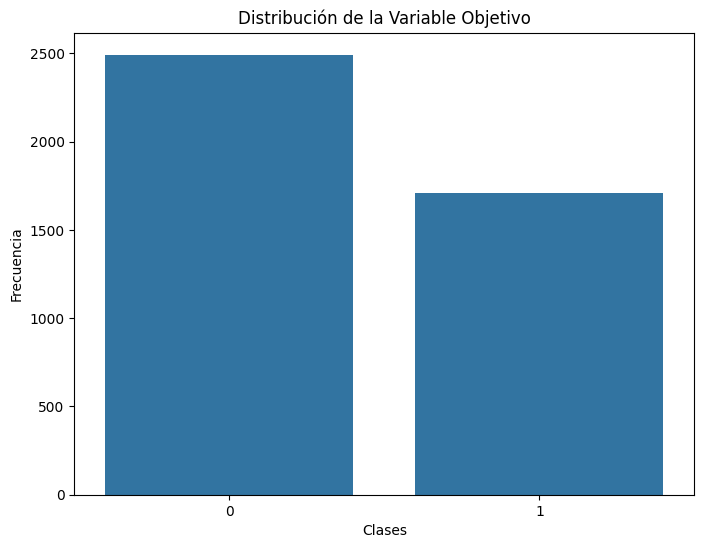

In [11]:
target_distribution = df['target'].value_counts()
print(target_distribution)
plt.figure(figsize=(8,6))
sns.countplot(x='target', data=df)
plt.title('Distribución de la Variable Objetivo')
plt.xlabel('Clases')
plt.ylabel('Frecuencia')
plt.show()

Logro notar que la variable target tiene una distribución de 60-40 entre los que tienen virus y quienes no.

Analizo si tengo columnas con valores negativos

In [12]:
negative_columns = [col for col in df.columns if col not in ['Laboral', 'Genero'] and (df[col] < 0).any()]

print("Columnas con valores negativos:", negative_columns)

Columnas con valores negativos: ['BLD01', 'BLD02', 'BLD03', 'LVL']


Analizo el porcentaje de nulos de cada columa.

In [13]:
round((df.isnull().sum()/df.shape[0])*100,2)

Edad       19.57
Genero     40.05
Peso        0.00
Laboral     0.00
hijos       0.00
BLD01       0.00
REC1        0.00
REC2        0.00
REC3        0.00
REC4        0.00
REC5        0.00
BLD02       0.00
BLD03       0.00
LVL        12.55
target      0.00
dtype: float64

# Cómo voy a trabajar con los datos

Veo que las columnas Edad, Genero y LVL poseen valores nulos. En el caso de Edad y LVL, el porcentaje es bajo, por lo que podría imputar sus valores nulos, eliminar las columnas o decantarme por eliminar las filas donde esas columnas cueten con valores nulos.

Para la columna Genero, el valor es muy alto. Si elimino los registros en null de esa columna voy a perder el 40% de mi dataset. Tengo que, o bien imputar sus valores, o eliminar la columna.

Considero que la columna Genero no es significativa en lo que se refiere a decidir si un paciente tiene un virus o no. La vería importante si estuviéramos analizando un caso de disparidad salarial. Al no considerarla importante para este dataset, la eliminaré.

Las columnas de Edad y LVL cuentan con valores nulos, y puedo ver además que LVL posee outliers. Por lo que voy a tener que imputar ambas columnas (en el caso de Edad, para completar nulos; y en el caso de LVL, para completar nulos y eliminar los outliers)

Otra transformación que debo hacer es convertir la columna Laboral en dummies para no tener que trabajar con columnas categóricas. Junto con aplicar un escalado a las columnas Edad, Peso, REC2, REC3, REC4, REC5 y LVL, debido a que sus valores son muy grandes y podrían tener más peso en el modelo.

Si quiero aplicar un modelo Bayes Multinomial, tengo que aplicar un escalado a las columnas negativas que obtuve más arriba, puesto a que bayes multinomial me arroja error si quiero trabajar con negativos.

# Definición de Pipelies

In [14]:
#Paso las columnas del Dataset a las variables X e y. X serán los datos a analizar, mientras que y será el objetivo de mi analisis
X = df.drop("target", axis=1)
y = df["target"]

#Divido los conjuntos en dos. Entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, test_size=0.3)

In [15]:
#Defino los pasos comunes de los Pipelines (todas las transformaciones que mencioné más arriba)
common_steps = [
    ("ColumnDropper",ColumnDropper(columns=["Genero"])),
    ("NullImputer",NullImputer(columns=["Edad","LVL"],strategy='median')),
    ("OutlierImputer",OutlierImputer(columns=["LVL"])),
    ("OneHot",ColOneHot(columns=["Laboral"])),
    ("StardardScaler",ColScaler(columns=["Edad","Peso","REC2","REC3","REC4","REC5","LVL"], scaler=StandardScaler()))
]

#Bayes multinomial no soporta valores negativos, por lo que crearé un pipeline que use MinMaxScaler para que no queden negativos.

multinomial_steps = [
    ("ColumnDropper",ColumnDropper(columns=["Genero"])),
    ("NullImputer",NullImputer(columns=["Edad","LVL"],strategy='median')),
    ("OutlierImputer",OutlierImputer(columns=["LVL"])),
    ("OneHot",ColOneHot(columns=["Laboral"])),
    ("MinMaxScaler",ColScaler(columns=["Edad","Peso","REC2","REC3","REC4","REC5","BLD01","BLD02","BLD03","LVL"], scaler=MinMaxScaler(feature_range=(0, 1))))
]

# GridSearchCV

Voy a usar GridSearchCV para evaluar diferentes hiperparámetros para cada uno de los modelos que vimos durante la materia.

Modelo KNN

In [16]:
# Defino el pipeline para las transformaciones
pipeline = Pipeline(steps=common_steps + [("classifier", KNeighborsClassifier())])

# Hiperparámetro de KNN. Cantidad de vecinos. Busco de 3 a 117, avanzando por los impares
param_grid = {
    'classifier__n_neighbors': list(range(3, 117, 2))
}

# GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=5)

# Ajusto GridSearchCV a los datos
grid_search.fit(X, y)

# Veo la mejor combinación de hiper parámetros
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Mejor modelo
best_model = grid_search.best_estimator_

Best parameters found:  {'classifier__n_neighbors': 19}
Best cross-validation score: 0.76


Modelo Random Forest

In [17]:
# Defino el pipeline para las transformaciones
pipeline = Pipeline(steps=common_steps + [("classifier", RandomForestClassifier())])

# Defino los hiperparámetros para Random Forest.
# N estimators: pruebo co 100, 200, 300 y 500
# Max Depth: pruebo con 10, 20 y 30
param_grid = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__max_depth': [10, 20, 30]
}

# GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=5)

# Ajusto GridSearchCV a los datos
grid_search.fit(X, y)

# Veo la mejor combinación de hiper parámetros
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Mejor modelo
best_model = grid_search.best_estimator_

Best parameters found:  {'classifier__max_depth': 20, 'classifier__n_estimators': 300}
Best cross-validation score: 0.80


In [22]:
#También puedo utilizar Randomized Search CV para buscar si el modelo mejora utilizando mas combinación de hiper parámetros
pipeline = Pipeline(steps=common_steps + [("classifier", RandomForestClassifier())])

param_grid = {
    'classifier__n_estimators': [30,60,90,120,150,180],
    'classifier__max_depth': [3,4,5,6,7,8],
    'classifier__criterion': ['gini','entropy','log_loss'],
    'classifier__max_features': ['sqrt','log2',None],
    'classifier__min_samples_leaf': [2,4,6,8,10],
    'classifier__min_samples_split': [2,4,6,8,10,14]
}

# Configuro RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipeline,param_distributions=param_grid,scoring='accuracy',cv=5,n_jobs=-1)

# Ajusto Random Search a los datos
random_search.fit(X_train, y_train)

# Veo la mejor combinación de hiper parámetros
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: {:.2f}".format(random_search.best_score_))

Best parameters found:  {'classifier__n_estimators': 60, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 10, 'classifier__max_features': None, 'classifier__max_depth': 5, 'classifier__criterion': 'gini'}
Best cross-validation score: 0.79


Siendo que RandomForest tiene un costo computacional alto, me quedaré con los hiperparámetros n_estimators y max_depth obtenidos con GridSearch.

Modelo Decision Tree

In [23]:
# Defino el pipeline para las transformaciones
pipeline = Pipeline(steps=common_steps + [("classifier", DecisionTreeClassifier())])

# Defino los hiperparámetros para Decision Tree.
# Max Depth: pruebo con 10, 20, 30 y 40.
# Min Samples Split: pruebo con 2, 5, 10, 15, 20.
# Min Samples Leaf: pruebo con 1, 2, 4, 6, 8, 10, 20, 30, 40, 50.
param_grid = {
    'classifier__max_depth': [10, 20, 30, 40],
    'classifier__min_samples_split': [2, 5, 10, 15, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 6, 8, 10, 20, 30, 40, 50]
}

# GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=5)

# Ajusto GridSearchCV a los datos
grid_search.fit(X, y)

# Veo la mejor combinación de hiper parámetros
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Mejor modelo
best_model = grid_search.best_estimator_

Best parameters found:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 50, 'classifier__min_samples_split': 2}
Best cross-validation score: 0.78


Bayes Multinomial

In [24]:
# Defino el pipeline para las transformaciones
pipeline = Pipeline(steps=multinomial_steps + [("classifier", MultinomialNB())])

# Defino los hiperparámetros para Bayes Multinomial
#Alpha: pruebo con 0.1, 0.5, 1.0 y 2.0
#Fit prior: pruebo con True y False
param_grid = {
    'classifier__alpha': [0.1, 0.5, 1.0, 2.0],
    'classifier__fit_prior' : [True, False]
}

# GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=5)

# Ajusto GridSearchCV a los datos
grid_search.fit(X, y)

# Veo la mejor combinación de hiper parámetros
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Mejor modelo
best_model = grid_search.best_estimator_

Best parameters found:  {'classifier__alpha': 0.1, 'classifier__fit_prior': False}
Best cross-validation score: 0.66


Bayes Gaussiano

In [32]:
# Defino el pipeline para las transformaciones
pipeline = Pipeline(steps=common_steps + [("classifier", GaussianNB())])

# Defino los hiperparámetros para Bayes Multinomial
# var_smoothing: pruebo con 1e-9, 1e-8, 1e-7, 1e-6
param_grid = {
    'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=5)

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Resultados de la mejor combinación de hiperparámetros
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

Best parameters found:  {'classifier__var_smoothing': 1e-09}
Best cross-validation score: 0.72


Regresion Logistica

In [25]:
# Defino el pipeline para las transformaciones
pipeline = Pipeline(steps=common_steps + [("classifier", LogisticRegression(max_iter=1000))])

# Defino los hiperparámetros para Regresion Logistica
#Penalty: pruebo l1, l2 y elasticnet
#C: pruebo con 0.001, 0.01, 0.1, 1.0 y 10.0
#Fit intercept: uso True y False
param_grid = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__C': [0.001, 0.01, 0.1, 1.0, 10.0] ,
    'classifier__fit_intercept' : [True, False]
}

# GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=5)

# Ajusto GridSearchCV a los datos
grid_search.fit(X, y)

# Veo la mejor combinación de hiper parámetros
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Mejor modelo
best_model = grid_search.best_estimator_


Best parameters found:  {'classifier__C': 1.0, 'classifier__fit_intercept': True, 'classifier__penalty': 'l2'}
Best cross-validation score: 0.75


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
100 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)

Regresion Lineal (para este modelo, en vez de accuracy busco un error cuadrático medio)

In [26]:
# Defino el pipeline para las transformaciones
pipeline = Pipeline(steps=common_steps + [("regressor", LinearRegression())])

# Defino los hiperparámetros para Regresion Lineal
# Fit intercept: Pruebo con True y False
param_grid = {
    'regressor__fit_intercept': [True, False],
}

# GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Ajusto GridSearchCV a los datos
grid_search.fit(X, y)

# Veo la mejor combinación de hiper parámetros
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score (negative MSE): {:.2f}".format(grid_search.best_score_))

# Mejor modelo
best_model = grid_search.best_estimator_


Best parameters found:  {'regressor__fit_intercept': True}
Best cross-validation score (negative MSE): -0.19


# Buscando el mejor modelo

Creo los pipelines utilizando los mejores modelos obtenidos

In [33]:
#Defino los pipelines diferentes que voy a usar. Estarán compuestos por los pasos de cada uno y la aplicación de un modelo

pipelines = [
    Pipeline(steps=common_steps + [("clf_knn_47", KNeighborsClassifier(n_neighbors=19))]),
    Pipeline(steps=common_steps + [("clf_rf", RandomForestClassifier(n_estimators=300, max_depth=20))]),
    Pipeline(steps=common_steps + [("clf_dt", DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=2))]),
    Pipeline(steps=common_steps + [("clf_gnb", GaussianNB(var_smoothing=1e-09))]),
    Pipeline(steps=multinomial_steps + [("clf_mnb", MultinomialNB(alpha=1.0,fit_prior=False))]),
    Pipeline(steps=common_steps + [("clf_lr", LinearRegression(fit_intercept=True))]),
    Pipeline(steps=common_steps + [("clf_logreg", LogisticRegression(max_iter=1000, penalty='l2', C=1.0, fit_intercept=True))])
]

classifier_names = [
    "KNN",
    "Random Forest",
    "Decision Tree",
    "Gaussian NB",
    "Multinomial NB",
    "Linear Regression",
    "Logistic Regression"
]

In [34]:
# Validacion Cruzada de Pipelines
for name, pipeline in zip(classifier_names, pipelines):
    scores = cross_val_score(pipeline, X, y, cv=5)
    print(f"Cross-validated accuracy for {name}: {scores.mean():.2f} (std: {scores.std():.2f})")

Cross-validated accuracy for KNN: 0.76 (std: 0.01)
Cross-validated accuracy for Random Forest: 0.80 (std: 0.01)
Cross-validated accuracy for Decision Tree: 0.78 (std: 0.01)
Cross-validated accuracy for Gaussian NB: 0.73 (std: 0.01)
Cross-validated accuracy for Multinomial NB: 0.66 (std: 0.01)
Cross-validated accuracy for Linear Regression: 0.23 (std: 0.01)
Cross-validated accuracy for Logistic Regression: 0.75 (std: 0.01)


In [35]:
# Veo el Score de cada PipeLine
for name, pipeline in zip(classifier_names, pipelines):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    if name == "Linear Regression":
        mse = mean_squared_error(y_test, y_pred)
        print(f"MSE for {name}: {mse:.2f}")
    else:
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy for {name}: {accuracy:.2f}")

Accuracy for KNN: 0.77
Accuracy for Random Forest: 0.80
Accuracy for Decision Tree: 0.79
Accuracy for Gaussian NB: 0.74
Accuracy for Multinomial NB: 0.66
MSE for Linear Regression: 0.18
Accuracy for Logistic Regression: 0.76


Grafico de curvas ROC (Excluyo el modelo de Regresión Lineal porque no contiene Predict Proba)

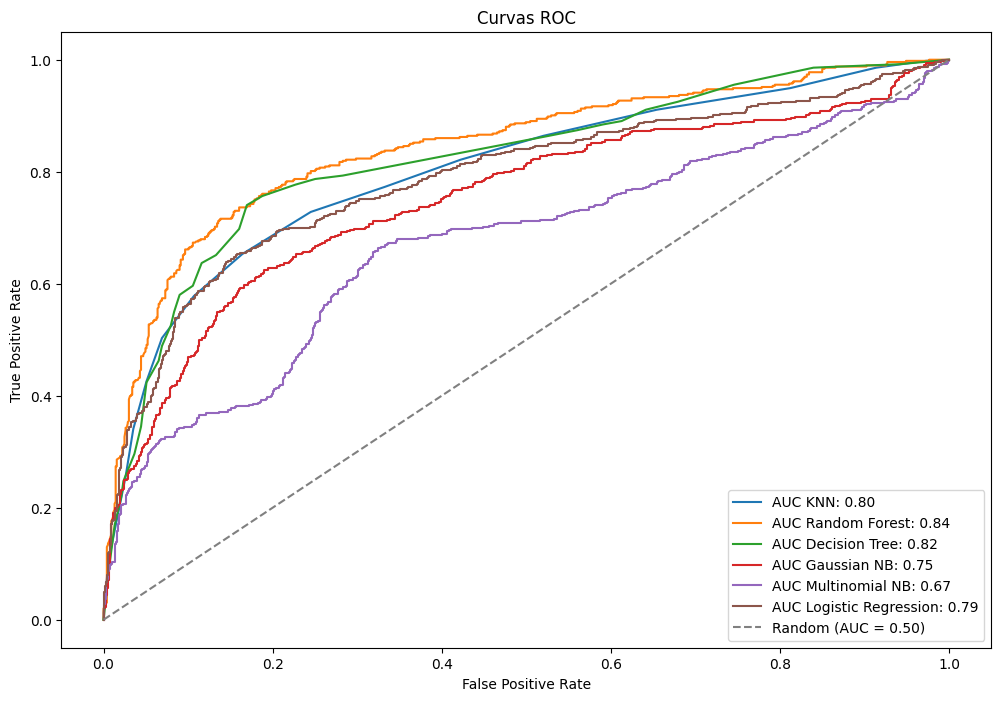

In [36]:
plt.figure(figsize=(12, 8))
for model, name in zip(pipelines, classifier_names):
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):
      y_score = model.predict_proba(X_test)[:,1]
      fpr, tpr, _ = roc_curve(y_test, y_score)
      roc_auc = auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'AUC {name}: {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC')
plt.legend()
plt.show()


El área bajo la curva del modelo Random Forest me indica que es el mejor modelo en comparación con Decision Tree y KNN. En tanto, el peor modelo para este caso sería el Bayes Multinomial, con un área bajo la curva muy baja casi cercana a la curva del azar.

# Intento mejorar el Score de mi modelo

Ahora que encontré el mejor modelo posible (Random Forest), intentaré mejorando aplicando otras transformaciones en el pipeline, o bien, revisando si la eliminación de columnas me ayuda en algo.

Reviso la correlación de las columnas que han permanecido.

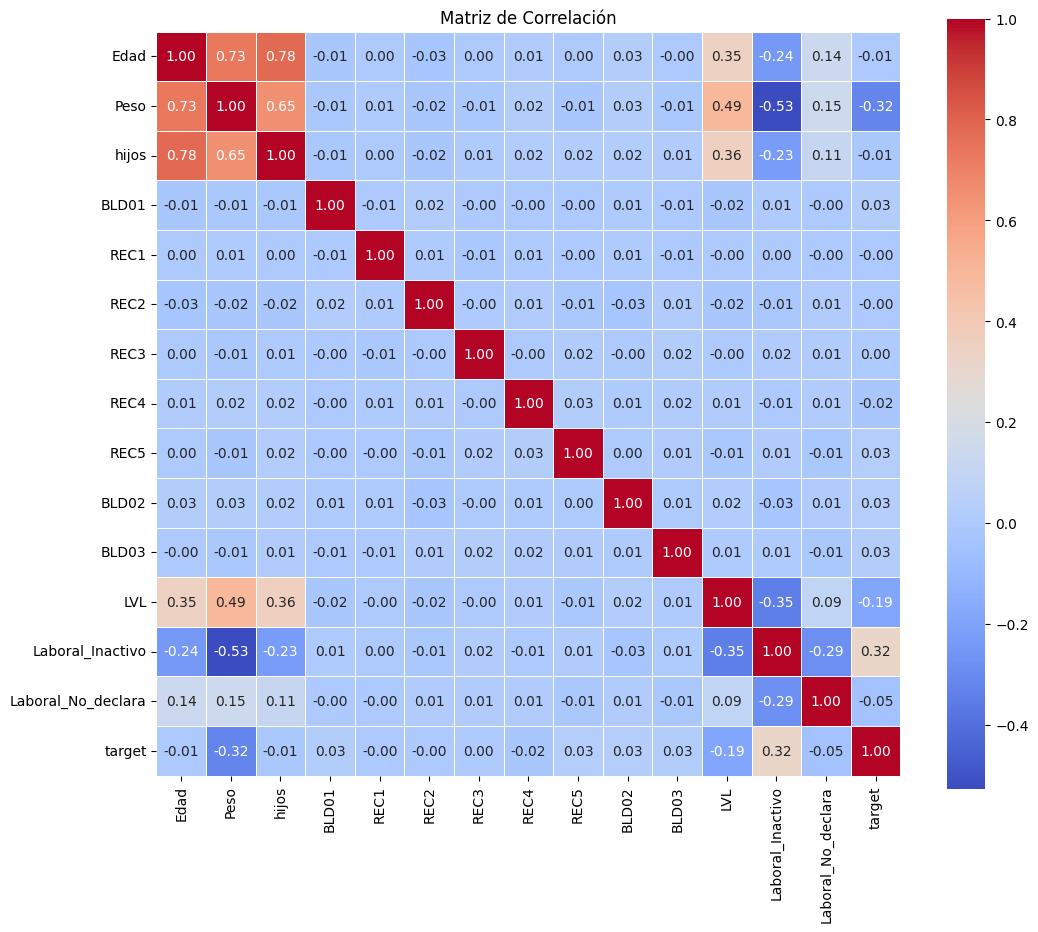

In [37]:
pipeline = Pipeline(steps=common_steps)

# Transformo X usando los pasos del pipeline
X_transformed = pipeline.fit_transform(X,y)

# Combino X e y en un único DataFrame
df_mat = pd.concat([X_transformed, y], axis=1)

# Calculo la matriz de correlación
correlation_matrix = df_mat.corr()

# Configurar el tamaño de la figura para el heatmap
plt.figure(figsize=(12, 10))

# Crear el heatmap usando seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)

# Configurar el título y mostrar el heatmap
plt.title('Matriz de Correlación')
plt.show()

Puedo notar que las columnas de Edad, Peso e hijos están relacionadas en este dataset, e igualmente pasa con la columna LVL. En cambio, las columnas BLD0 y REC no están demasiado relacionadas, incluso entre sí. Por eso mismo, tomaré la decisión de dropear algunas de ellas en algunos pipelines para ver que tanto mejora mi score, e incluso en otro podría utilizar el cálculo del promedio para crear una nueva columna.

Otra alternativa que podría serme útil sería utilizar la media o la moda para imputar las columnas de Edad y LVL.

In [38]:
#Pipeline con los pasos que usé para obtener el mejor modelo
pasos_comunes = [
    ("ColumnDropper",ColumnDropper(columns=["Genero"])),
    ("NullImputer",NullImputer(columns=["Edad","LVL"],strategy='median')),
    ("OutlierImputer",OutlierImputer(columns=["LVL"])),
    ("OneHot",ColOneHot(columns=["Laboral"])),
    ("StardardScaler",ColScaler(columns=["Edad","Peso","REC2","REC3","REC4","REC5","LVL"], scaler=StandardScaler()))
]

#Pipeline sin ninguna columna de BLD0 o REC
sin_bld_rec = [
    ("ColumnDropper",ColumnDropper(columns=["Genero","BLD01","BLD02","BLD03","REC1","REC2","REC3","REC4","REC5",])),
    ("NullImputer",NullImputer(columns=["Edad","LVL"],strategy='median')),
    ("OutlierImputer",OutlierImputer(columns=["LVL"])),
    ("OneHot",ColOneHot(columns=["Laboral"])),
    ("StardardScaler",ColScaler(columns=["Edad","Peso","LVL"], scaler=StandardScaler()))
]

#Pasos comunes, pero ahora con media para Edad y LVL
pasos_comunes_mean = [
    ("ColumnDropper",ColumnDropper(columns=["Genero"])),
    ("NullImputer",NullImputer(columns=["Edad","LVL"],strategy='mean')),
    ("OutlierImputer",OutlierImputer(columns=["LVL"])),
    ("OneHot",ColOneHot(columns=["Laboral"])),
    ("StardardScaler",ColScaler(columns=["Edad","Peso","REC2","REC3","REC4","REC5","LVL"], scaler=StandardScaler()))
]

#Sin BLD0 y REC con media para Edad y LVL
sin_bld_rec_mean = [
    ("ColumnDropper",ColumnDropper(columns=["Genero","BLD01","BLD02","BLD03","REC1","REC2","REC3","REC4","REC5",])),
    ("NullImputer",NullImputer(columns=["Edad","LVL"],strategy='mean')),
    ("OutlierImputer",OutlierImputer(columns=["LVL"])),
    ("OneHot",ColOneHot(columns=["Laboral"])),
    ("StardardScaler",ColScaler(columns=["Edad","Peso","LVL"], scaler=StandardScaler()))
]

#Pasos comunes, pero ahora con moda para Edad y LVL
pasos_comunes_mode = [
    ("ColumnDropper",ColumnDropper(columns=["Genero"])),
    ("NullImputer",NullImputer(columns=["Edad","LVL"],strategy='mode')),
    ("OutlierImputer",OutlierImputer(columns=["LVL"])),
    ("OneHot",ColOneHot(columns=["Laboral"])),
    ("StardardScaler",ColScaler(columns=["Edad","Peso","REC2","REC3","REC4","REC5","LVL"], scaler=StandardScaler()))
]

#Sin BLD0 y REC con moda para Edad y LVL
sin_bld_rec_mode = [
    ("ColumnDropper",ColumnDropper(columns=["Genero","BLD01","BLD02","BLD03","REC1","REC2","REC3","REC4","REC5",])),
    ("NullImputer",NullImputer(columns=["Edad","LVL"],strategy='mode')),
    ("OutlierImputer",OutlierImputer(columns=["LVL"])),
    ("OneHot",ColOneHot(columns=["Laboral"])),
    ("StardardScaler",ColScaler(columns=["Edad","Peso","LVL"], scaler=StandardScaler()))
]

In [39]:
#Defino los pipelines diferentes que voy a usar.

pipelines = [
    Pipeline(steps=pasos_comunes + [("common", RandomForestClassifier(n_estimators=300, max_depth=20))]),
    Pipeline(steps=sin_bld_rec + [("s_b_r", RandomForestClassifier(n_estimators=300, max_depth=20))]),
    Pipeline(steps=pasos_comunes_mean + [("common_mean", RandomForestClassifier(n_estimators=300, max_depth=20))]),
    Pipeline(steps=sin_bld_rec_mean + [("s_b_r_mean", RandomForestClassifier(n_estimators=300, max_depth=20))]),
    Pipeline(steps=pasos_comunes_mode + [("common_mode", RandomForestClassifier(n_estimators=300, max_depth=20))]),
    Pipeline(steps=sin_bld_rec_mode + [("s_b_r_mode", RandomForestClassifier(n_estimators=300, max_depth=20))])
]

classifier_names = [
    "Comunes",
    "S_BLD_REC",
    "Comunes_Media",
    "S_BLD_REC_Media",
    "Comunes_Moda",
    "S_BLD_REC_Moda"
]

In [40]:
# Evaluo el score de cada modelo incluido en cada pipeline
for name, pipeline in zip(classifier_names, pipelines):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    if name == "Linear Regression":
        mse = mean_squared_error(y_test, y_pred)
        print(f"MSE for {name}: {mse:.2f}")
    else:
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy for {name}: {accuracy:.2f}")

Accuracy for Comunes: 0.80
Accuracy for S_BLD_REC: 0.74
Accuracy for Comunes_Media: 0.80
Accuracy for S_BLD_REC_Media: 0.75
Accuracy for Comunes_Moda: 0.80
Accuracy for S_BLD_REC_Moda: 0.75


Noto que dropear todas esas columnas no mejora mi score, e incluso lo reduce. Por lo que trataré de calcular un promedio entre ellas y quedarme con esa nueva columna.

Creo nuevos pasos para pipelines que incluyan el promedio.

In [55]:
#Promedio de columnas con Mediana
bld_rec_avg = [
    ("ColumnDropper",ColumnDropper(columns=["Genero"])),
    ("NullImputer",NullImputer(columns=["Edad","LVL"],strategy='median')),
    ("OutlierImputer",OutlierImputer(columns=["LVL"])),
    ("OneHot",ColOneHot(columns=["Laboral"])),
    ("StardardScaler",ColScaler(columns=["Edad","Peso","REC2","REC3","REC4","REC5","LVL"], scaler=StandardScaler())),
    ("Averager_B",ColumnAverager(columns=["BLD01","BLD02","BLD03"],new_column_name="BLDAVG")),
    ("Averager_R",ColumnAverager(columns=["REC1","REC2","REC3","REC4","REC5"],new_column_name="RECAVG")),
    ("ColumnsAVGDropper",ColumnDropper(columns=["BLD01","BLD02","BLD03","REC1","REC2","REC3","REC4","REC5"]))
]

#Promedio de columnas con Media
bld_rec_avg_mean = [
    ("ColumnDropper",ColumnDropper(columns=["Genero"])),
    ("NullImputer",NullImputer(columns=["Edad","LVL"],strategy='mean')),
    ("OutlierImputer",OutlierImputer(columns=["LVL"])),
    ("OneHot",ColOneHot(columns=["Laboral"])),
    ("StardardScaler",ColScaler(columns=["Edad","Peso","REC2","REC3","REC4","REC5","LVL"], scaler=StandardScaler())),
    ("Averager_B",ColumnAverager(columns=["BLD01","BLD02","BLD03"],new_column_name="BLDAVG")),
    ("Averager_R",ColumnAverager(columns=["REC1","REC2","REC3","REC4","REC5"],new_column_name="RECAVG")),
    ("ColumnsAVGDropper",ColumnDropper(columns=["BLD01","BLD02","BLD03","REC1","REC2","REC3","REC4","REC5"]))
]

#Promedio de columnas con Moda
bld_rec_avg_mode = [
    ("ColumnDropper",ColumnDropper(columns=["Genero"])),
    ("NullImputer",NullImputer(columns=["Edad","LVL"],strategy='mode')),
    ("OutlierImputer",OutlierImputer(columns=["LVL"])),
    ("OneHot",ColOneHot(columns=["Laboral"])),
    ("StardardScaler",ColScaler(columns=["Edad","Peso","REC2","REC3","REC4","REC5","LVL"], scaler=StandardScaler())),
    ("Averager_B",ColumnAverager(columns=["BLD01","BLD02","BLD03"],new_column_name="BLDAVG")),
    ("Averager_R",ColumnAverager(columns=["REC1","REC2","REC3","REC4","REC5"],new_column_name="RECAVG")),
    ("ColumnsAVGDropper",ColumnDropper(columns=["BLD01","BLD02","BLD03","REC1","REC2","REC3","REC4","REC5"]))
]

In [56]:
#Defino los pipelines diferentes que voy a usar.

pipelines = [
    Pipeline(steps=pasos_comunes + [("common", RandomForestClassifier(n_estimators=300, max_depth=20))]),
    Pipeline(steps=bld_rec_avg + [("s_b_r", RandomForestClassifier(n_estimators=300, max_depth=20))]),
    Pipeline(steps=pasos_comunes_mean + [("common_mean", RandomForestClassifier(n_estimators=300, max_depth=20))]),
    Pipeline(steps=bld_rec_avg_mean + [("s_b_r_mean", RandomForestClassifier(n_estimators=300, max_depth=20))]),
    Pipeline(steps=pasos_comunes_mode + [("common_mode", RandomForestClassifier(n_estimators=300, max_depth=20))]),
    Pipeline(steps=bld_rec_avg_mode + [("s_b_r_mode", RandomForestClassifier(n_estimators=300, max_depth=20))])
]

classifier_names = [
    "Comunes",
    "AVG",
    "Comunes_Media",
    "AVG_Media",
    "Comunes_Moda",
    "AVG_Moda"
]

In [57]:
# Evaluo el score de cada modelo incluido en cada pipeline
for name, pipeline in zip(classifier_names, pipelines):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    if name == "Linear Regression":
        mse = mean_squared_error(y_test, y_pred)
        print(f"MSE for {name}: {mse:.2f}")
    else:
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy for {name}: {accuracy:.2f}")

Accuracy for Comunes: 0.80
Accuracy for AVG: 0.76
Accuracy for Comunes_Media: 0.80
Accuracy for AVG_Media: 0.76
Accuracy for Comunes_Moda: 0.80
Accuracy for AVG_Moda: 0.77


In [58]:
# Validacion Cruzada de Pipeline
for name, pipeline in zip(classifier_names, pipelines):
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    print(f"Cross-validated accuracy for {name}: {scores.mean():.2f} (std: {scores.std():.2f})")

Cross-validated accuracy for Comunes: 0.80 (std: 0.01)
Cross-validated accuracy for AVG: 0.76 (std: 0.01)
Cross-validated accuracy for Comunes_Media: 0.80 (std: 0.01)
Cross-validated accuracy for AVG_Media: 0.76 (std: 0.01)
Cross-validated accuracy for Comunes_Moda: 0.80 (std: 0.01)
Cross-validated accuracy for AVG_Moda: 0.76 (std: 0.01)


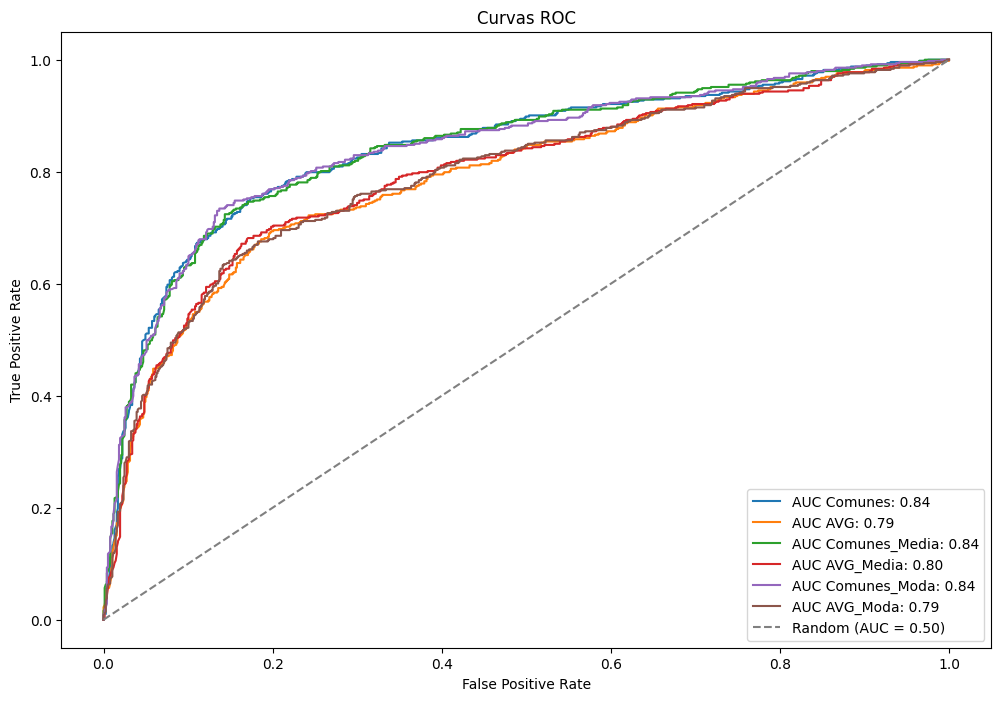

In [59]:
plt.figure(figsize=(12, 8))
for model, name in zip(pipelines, classifier_names):
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):
      y_score = model.predict_proba(X_test)[:,1]
      fpr, tpr, _ = roc_curve(y_test, y_score)
      roc_auc = auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'AUC {name}: {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC')
plt.legend()
plt.show()

Noto que realizar promedios entre esas columnas no aumenta el score, pero implica más trabajo. Por lo que me quedaré con todas las columnas. Una última prueba que se podría hacer sería la utilización de MinMaxScaler en lugar de StandardScaler, y aplicaría esa transformación a cada columna numérica.

In [60]:
#Pipeline con los pasos que usé para obtener el mejor modelo
pasos_comunes_minmax = [
    ("ColumnDropper",ColumnDropper(columns=["Genero"])),
    ("NullImputer",NullImputer(columns=["Edad","LVL"],strategy='median')),
    ("OutlierImputer",OutlierImputer(columns=["LVL"])),
    ("OneHot",ColOneHot(columns=["Laboral"])),
    ("StardardScaler",ColScaler(columns=["Edad","Peso","REC2","REC3","REC4","REC5","BLD01","BLD02","BLD03","LVL"], scaler=MinMaxScaler(feature_range=(0, 1))))
]

#Pasos comunes, pero ahora con media para Edad y LVL
pasos_comunes_mean_minmax = [
    ("ColumnDropper",ColumnDropper(columns=["Genero"])),
    ("NullImputer",NullImputer(columns=["Edad","LVL"],strategy='mean')),
    ("OutlierImputer",OutlierImputer(columns=["LVL"])),
    ("OneHot",ColOneHot(columns=["Laboral"])),
    ("StardardScaler",ColScaler(columns=["Edad","Peso","REC2","REC3","REC4","REC5","BLD01","BLD02","BLD03","LVL"], scaler=MinMaxScaler(feature_range=(0, 1))))
]

#Pasos comunes, pero ahora con moda para Edad y LVL
pasos_comunes_mode_minmax = [
    ("ColumnDropper",ColumnDropper(columns=["Genero"])),
    ("NullImputer",NullImputer(columns=["Edad","LVL"],strategy='mode')),
    ("OutlierImputer",OutlierImputer(columns=["LVL"])),
    ("OneHot",ColOneHot(columns=["Laboral"])),
    ("StardardScaler",ColScaler(columns=["Edad","Peso","REC2","REC3","REC4","REC5","BLD01","BLD02","BLD03","LVL"], scaler=MinMaxScaler(feature_range=(0, 1))))
]

In [61]:
#Defino los pipelines diferentes que voy a usar.

pipelines = [
    Pipeline(steps=pasos_comunes + [("common", RandomForestClassifier(n_estimators=300, max_depth=20))]),
    Pipeline(steps=pasos_comunes_mean + [("common_mean", RandomForestClassifier(n_estimators=300, max_depth=20))]),
    Pipeline(steps=pasos_comunes_mode + [("common_mode", RandomForestClassifier(n_estimators=300, max_depth=20))])
]

classifier_names = [
    "Comunes_MinMax",
    "Comunes_Media_MinMax",
    "Comunes_Moda_MinMax"
]

In [62]:
# Evaluo el score de cada modelo incluido en cada pipeline
for name, pipeline in zip(classifier_names, pipelines):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    if name == "Linear Regression":
        mse = mean_squared_error(y_test, y_pred)
        print(f"MSE for {name}: {mse:.2f}")
    else:
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy for {name}: {accuracy:.2f}")

Accuracy for Comunes_MinMax: 0.81
Accuracy for Comunes_Media_MinMax: 0.80
Accuracy for Comunes_Moda_MinMax: 0.81


In [63]:
# Validacion Cruzada de Pipeline
for name, pipeline in zip(classifier_names, pipelines):
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    print(f"Cross-validated accuracy for {name}: {scores.mean():.2f} (std: {scores.std():.2f})")

Cross-validated accuracy for Comunes_MinMax: 0.80 (std: 0.01)
Cross-validated accuracy for Comunes_Media_MinMax: 0.80 (std: 0.01)
Cross-validated accuracy for Comunes_Moda_MinMax: 0.80 (std: 0.01)


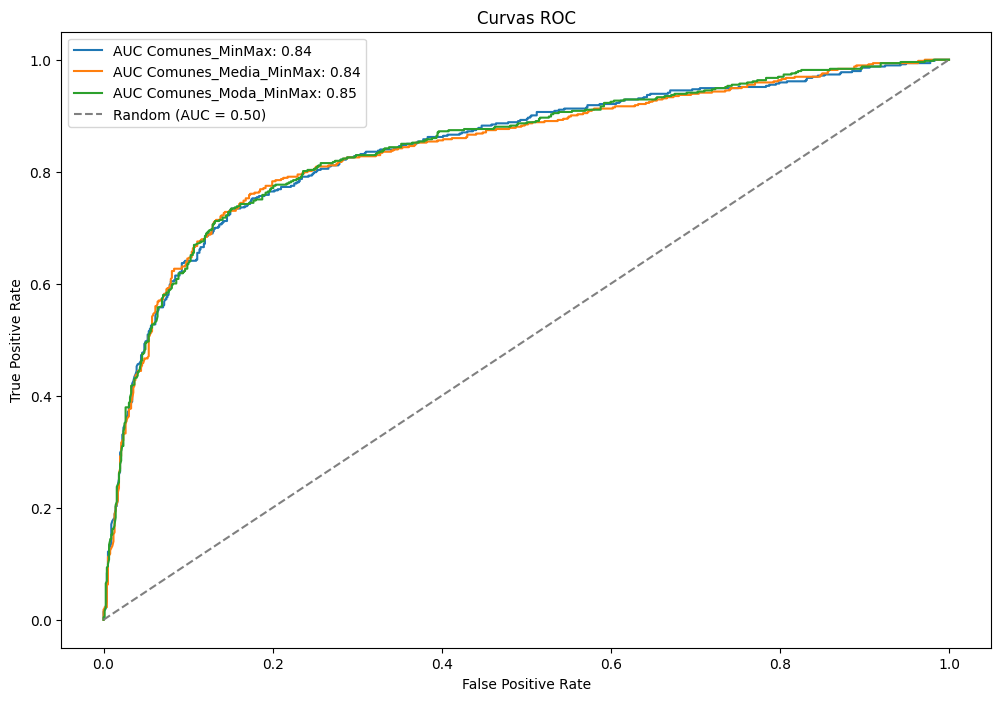

In [64]:
plt.figure(figsize=(12, 8))
for model, name in zip(pipelines, classifier_names):
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):
      y_score = model.predict_proba(X_test)[:,1]
      fpr, tpr, _ = roc_curve(y_test, y_score)
      roc_auc = auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'AUC {name}: {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC')
plt.legend()
plt.show()

Veo que el Score del modelo continúa rondeando el 0.8 y el área bajo la curva se mantiene cerca del 0.85. Por lo cual, me quedaré con la primera opción (pasos comunes, con StandardScaler) ya que implica menos columnas que escalar y eliminar.

Evalúo modelo de forma individual

In [74]:
transformaciones = Pipeline(steps=common_steps)
mi_clasificador = Pipeline(steps=common_steps + [("clf_rf", RandomForestClassifier(n_estimators=300, max_depth=20))])

mi_clasificador.fit(X_train, y_train)

y_pred = mi_clasificador.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8023809523809524


## Evaluacion final - Docente + Alumno

In [77]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

PRODUCCION = False
best_clf = RandomForestClassifier(n_estimators=300, max_depth=20) #Asignar aqui el mejor clasificador posible (previamente entrenado)

#Leemos el dataset de evaluacion, simulando produccion
if PRODUCCION==False:
    df = pd.read_csv("TP_Virus_Alumnos.csv")
    _, df = train_test_split(df, test_size=0.3, random_state=42)
else:
    df = pd.read_csv("TP_Virus_Evaluacion.csv")
#Dividimos en target y predictoras

X_prod = df.drop("target", axis=1)
y_prod = df["target"]

#Transformaciones
X_prod = transformaciones.transform(X_prod)
best_clf.fit(X_prod,y_prod)

#Evaluacion final
y_pred = best_clf.predict(X_prod)
print(classification_report(y_prod, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       739
           1       1.00      1.00      1.00       521

    accuracy                           1.00      1260
   macro avg       1.00      1.00      1.00      1260
weighted avg       1.00      1.00      1.00      1260

